### Is This Bathroom Occupied?
***

The Aug 4th 2017 Riddler Classic from [FiveThirtyEight]() asks the following: 

> There is a bathroom in your office building that has only one toilet. There is a small sign stuck to the outside of the door that you can slide from “Vacant” to “Occupied” so that no one else will try the door handle (theoretically) when you are inside. Unfortunately, people often forget to slide the sign to “Occupied” when entering, and they often forget to slide it to “Vacant” when exiting.

> Assume that 1/3 of bathroom users don’t notice the sign upon entering or exiting. Therefore, whatever the sign reads before their visit, it still reads the same thing during and after their visit. Another 1/3 of the users notice the sign upon entering and make sure that it says “Occupied” as they enter. However, they forget to slide it to “Vacant” when they exit. The remaining 1/3 of the users are very conscientious: They make sure the sign reads “Occupied” when they enter, and then they slide it to “Vacant” when they exit. Finally, assume that the bathroom is occupied exactly half of the time, all day, every day.

> Two questions about this workplace situation:

> 1. If you go to the bathroom and see that the sign on the door reads “Occupied,” what is the probability that the bathroom is actually occupied?
<p> </p> 
>2. If the sign reads “Vacant,” what is the probability that the bathroom actually is vacant?

> _Extra credit_: What happens as the percentage of conscientious bathroom users changes? 


**Notation**: In this problem we're going to be keeping track of both the state of usage of the bathroom and the state of the sign, so we'll need some simple notation to keep things straight.  

The sign can be in two states: it can either indicate that the bathroom is occupied, which we denote $O$, or can indicate that the bathroom is vacant, which we denote $V$. 

For the usage state there are four possible cases: the bathroom can be empty, or one of three types of people can be in it.  We denote these four usage states as follows 

\begin{array}{c|c|c}
\textrm{usage state} & \textrm{label} & \textrm{behavior} \\
\hline
\textrm{empty} & E & \textrm{does not change sign at all} \\
\hline
\textrm{apathetic person} & A & \textrm{does not change sign upon entrance or exit} \\
\hline
\textrm{selfish person} & S & \textrm{changes sign to $O$ upon entrance and leaves sign at $O$ on exit } \\
\hline
\textrm{conscientious person} & C & \textrm{changes to $O$ upon entrance and changes sign to $V$ on exit } 
\end{array}

Note that there are then 8 possible usage-sign state combinations.  

**Simulation Approach**: We start by simulating the usage of the bathroom and recording the frequency that the system is in each usage-sign state combination and then divide each frequency by the total number of observations we've made.  If we run the simulation long enough then these ratios should be a good approximation of the probability of the system being in each usage-sign state combination at any given time.    

In [1]:
using Distributions

In [2]:
function exit_bathroom(u, s)
    # ------------------------------------------------------------
    # Function to simulate sign changes on exit from bathroom 
    # based on user type 
    # Parameters: 
    #     u: usage state (1-E, 2-A, 3-S, 4-C)
    #     s: current sign state (1-vacant, 2-occupied)
    # ------------------------------------------------------------
    
    if (u == 1) | (u == 2)
        return s 
    elseif u == 3 
        return 2 
    else
        return 1 
    end 
    
end

function enter_bathroom(u, s)
    # ------------------------------------------------------------
    # Function to simulate sign changes on entrance to bathroom 
    # based on user type 
    # Parameters: 
    #     u: usage state (1-E, 2-A, 3-S, 4-C)
    #     s: current sign state (1-vacant, 2-occupied)
    # ------------------------------------------------------------
    
    if (u == 1) | (u == 2)
        return s 
    else
        return 2 
    end 
    
end

function bathroom_trial(pc=1/3; thin=10)
    # ------------------------------------------------------------
    # Function to simulate one bathroom trial  
    # Parameters: 
    #     pc: probability of type C user 
    #     thin: frequency to collect observations
    # Notes: We assume that for a given probability of a 
    # type C user, the appearence of type A and S users are 
    # equally likely. 
    # ------------------------------------------------------------
    
    # Initialize counting matrix with dimensions (usage states x sign states)
    # where again usage denoted by (1-E, 2-A, 3-S, 4-C) and sign state denoted
    # by (1-vacant, 2-occupied)
    counts = zeros(4,2)
    
    # Initialize usage state from Multinouli distribution
    use_state = findfirst(rand(Multinomial(1,[1/2,(1-pc)/4,(1-pc)/4,pc/2])))
    
    # Initialize sign state (1-vacant, 2-occupied)
    sign_state = findfirst(rand(Multinomial(1,[1/2,1/2])))
    
    for ii=1:1000 
        
        # current occupant leaves 
        sign_state = exit_bathroom(use_state, sign_state)
        
        # new occupant enters 
        use_state = findfirst(rand(Multinomial(1,[1/2,(1-pc)/4,(1-pc)/4,pc/2])))
        sign_state = enter_bathroom(use_state, sign_state)
        
        # record occupancy and sign state 
        if ii%thin == 0 
            counts[use_state, sign_state] += 1 
        end
        
    end
    
    return counts 
    
end

function bathroom_sim(pc::Float64, M::Int64)
    # ------------------------------------------------------------
    # Function to simulate M bathrom trials and estimate 
    # conditional state probabilities. 
    # Parameters: 
    #     pc: probability of conscientious user  
    #     M: number of individual trials to run
    # ------------------------------------------------------------
    
    # Initialize counting matrix with dimensions (usage states x sign states)
    # where again usage denoted by (1-E, 2-A, 3-S, 4-C) and sign state denoted
    # by (1-vacant, 2-occupied)
    counts = zeros(4,2)
    
    # Run many trials 
    for ii=1:M
        counts += bathroom_trial(pc) 
    end
    
    # Get estimated state probabilities 
    prob = counts / sum(counts)
    
    # Compute conditional probabilities 
    PFO = sum(prob[2:4,2]) / sum(prob[:,2])
    PEV = sum(prob[1,1]) / sum(prob[:,1])
    
    # Print conditional probabilities 
    @printf "Pr(actually occupied | sign says occupied) = %4.4f\n" PFO 
    @printf "Pr(actually vacant   | sign says vacant)   = %4.4f\n" PEV 
    
    return PFO, PEV
    
end

bathroom_sim (generic function with 1 method)

Note that our simulation actually estimates the long-term probability of being in any particular usage-sign state combination.  In other words, we approximate the full joint probabilities $Pr(\textrm{usage}, \textrm{sign})$.  But in reality we're after the conditional probabilities of the usage state give the state of the sign.  The code computes these conditional probabilities as  

$$
Pr(\textrm{actually occupied} ~|~ \textrm{sign says occupied}) = \frac{Pr(AO) + Pr(SO) + Pr(CO)}{Pr(EO) + Pr(AO) + Pr(SO) + Pr(CO)}
$$

and 

$$
Pr(\textrm{actually vacant} ~|~ \textrm{sign says vacant}) = \frac{Pr(EV)}{Pr(EV) + Pr(AV) + Pr(SV) + Pr(CV)}
$$

We run our simulation for 100K independent days where each day simulates 1000 bathroom usages and records the state of the system after every 10 usages.  Here are the results. 

In [5]:
bathroom_sim(1/3, 100000);

Pr(actually occupied | sign says occupied) = 0.6252
Pr(actually vacant   | sign says vacant)   = 0.7499



The simulation appears to indicate that if the sign says the bathroom is occupied then there is approximately a **62.5%** probability that the bathroom actually is occupied. 

Similarly, if the sign says the bathroom is vacant then there is approximately a **75%** probability that the bathroom actually is vacant. 

Let's see if we can back up these simulation results up with some theory. 

**Analytic Solution**: We solve the problem analytically by formulating the system as a discrete time-homogeneous Markov chain. By doing so we can analytically determine the stationary distribution of the Markov chain and thus know the long-term probability of being in any particular usage-sign state combination.  

We should first point out a simplifying fact about this particular system.  Note that it is actually impossible for the state combinations $SV$ and $CV$ to occur.  That is, according to the rules, it is impossible for a type $S$ or type $C$ person to be in the bathroom and have the sign read vacant.  This means that we can ignore these two states in the analysis.  

We start by formulating the matrix of transition probabilities between each combination of the six valid states.  Note that since this is still $6 \times 6 = 36$ combinations we will write down the transition matrix and explain how we arrive at just a few of the entries.  The transition matrix is 


$$
\begin{array}{c|c|c|c|c|c|c|c|c|c}
   & EV & AV  & EO & AO & SO & CO  & \\  
   \hline
EV &1/2 & 1/6 & 0  &0   &1/6 & 1/6 & \\
   \hline
AV &1/2 & 1/6 & 0  &0   &1/6 & 1/6 & \\
   \hline
EO &0   & 0   &1/2 &1/6 &1/6 & 1/6 & \\
   \hline
AO &0   & 0   &1/2 &1/6 &1/6 & 1/6 & \\
   \hline
SO &0   & 0   &1/2 &1/6 &1/6 & 1/6 & \\
   \hline
CO &1/2 & 1/6 &0   &0   &1/6 & 1/6 & 
\end{array}
$$

where here entry in row $i$ and column $j$ gives the probability that the state transitions from state $i$ to state $j$. 

Let's start by examining the row corresponding to the state $EO$.  We want to know the probability with which the system transitions from the state where the bathroom is empty and the sign says occupied to each of the other valid states. 

- **EO**$\rightarrow$**EV**: If the bathroom is still empty at the next time step then there is no way for the sign to change from $O$ to $V$, so this probability is 0 
- **EO**$\rightarrow$**AV**: If a type A person enters then he will not change the sign from $O$ to $V$, so this probability is 0 
- **EO**$\rightarrow$**EO**: If the bathroom is still empty at the next time step then the sign will remain $O$.  The bathroom stays empty with probably $1/2$
- **EO**$\rightarrow$**AO**: If a type A person enters then the sign will remain $O$.  A type A person enters with probably $1/2\cdot 1/3 = 1/6$
- **EO**$\rightarrow$**SO**: If a type S person enters then the sign will remain $O$.  A type S person enters with probably $1/2\cdot 1/3 = 1/6$
- **EO**$\rightarrow$**CO**: If a type C person enters then the sign will remain $O$.  A type C person enters with probably $1/2\cdot 1/3 = 1/6$

Let's also examine the row corresponding to the state $CO$. Note that when a type $C$ person leaves the bathroom they always changes the sign to $V$. 

- **CO**$\rightarrow$**EV**: The bathroom then remains empty with probably $1/2$. 
- **CO**$\rightarrow$**AV**: A type A person enters the bathroom (and doesn't change the sign) with probably $1/2\cdot 1/3 = 1/6$. 
- **CO**$\rightarrow$**EO**: If the bathroom remains empty after C leaves then there is no way for the sign to change to $O$.  Thus the probably is $0$
- **CO**$\rightarrow$**AO**: If a type A person enters then he won't change the sign to $O$, thus this probably is $0$. 
- **CO**$\rightarrow$**SO**: If a type S person enters then the sign will change to $O$.  A type S person enters with probably $1/2\cdot 1/3 = 1/6$
- **CO**$\rightarrow$**CO**: If a type C person enters then the sign will change to $O$.  A type C person enters with probably $1/2\cdot 1/3 = 1/6$

Under certain technical qualities of the Markov chain (which this particular problem satisfies) we can find the stationary distribution by finding the dominant eigenvector of the transpose of the transition matrix. The following function accomplishes this.  

In [12]:
function simple_bathroom_markov()
    # ------------------------------------------------------------
    # Function to find the stationary distribution of the 
    # bathroom Markov chain. States in the matrix are ordered 
    # as (EV, AV, EO, AO, SO, CO)
    # ------------------------------------------------------------

    # Construct to the transition matrix 
    P = [
        1/2  1/6  0  0   1/6  1/6 
        1/2  1/6  0  0   1/6  1/6 
        0    0   1/2 1/6 1/6  1/6 
        0    0   1/2 1/6 1/6  1/6 
        0    0   1/2 1/6 1/6  1/6 
        1/2  1/6 0   0   1/6  1/6 
    ]
    
    # Find the dominant eigenvector 
    lam, p = eigs(P', nev=1, which=:LM)
    p = real(p)
    p = p / sum(p)
    
    println("stationary distribution: ", p)
    
    return p 

end

simple_bathroom_markov (generic function with 1 method)

In [13]:
simple_bathroom_markov();

stationary distribution: [0.25; 0.0833333; 0.25; 0.0833333; 0.166667; 0.166667]


Thus the long-term probability of being in each of the valid states is given by 

$$
\begin{eqnarray}
\nonumber Pr(EV) &=& 1/4 \\
\nonumber Pr(AV) &=& 1/12 \\
\nonumber Pr(EO) &=& 1/4 \\
\nonumber Pr(AO) &=& 1/12 \\
\nonumber Pr(SO) &=& 1/6 \\
\nonumber Pr(CO) &=& 1/6 \\
\end{eqnarray}
$$

From the stationary distribution we can compute the conditional probabilities of interest:

$$
Pr(\textrm{actually occupied} ~|~ \textrm{sign says occupied}) = \frac{Pr(AO) + Pr(SO) + Pr(CO)}{Pr(EO) + Pr(AO) + Pr(SO) + Pr(CO)} = \frac{1/12+1/6+1/6}{1/4+1/12+1/6+1/6} = \frac{5}{8} = 0.625
$$

and 

$$
Pr(\textrm{actually vacant} ~|~ \textrm{sign says vacant}) = \frac{Pr(EV)}{Pr(EV) + Pr(AV)} =
\frac{1/4}{1/4+1/12} = \frac{3}{4} = 0.75
$$

Notice that the analytic results agree very well with our simulated results.  Thus we conclude that: 

- If the sign says the bathroom is occupied then there is a **62.5%** probability that the bathroom actually is occupied. 

- If the sign says the bathroom is vacant then there is a **75%** probability that the bathroom actually is vacant. 

**Extra Credit**: The extra credit questions asks what happens if the percentage of conscientious bathroom users changes.  Intuitively, it makes sense to believe that if more users are conscientious then the sign should become a better indicator of the actual usage state in the bathroom.  That is, the conditional probabilities of interest should approach 1.  Similarly, if fewer users are conscientious then we expect the conditional probabilities to go down. 

In order to solve this problem analytically we need to formulate the transition probabilities in terms of percentages of each type of user.  For simplicity, we'll make the assumption that we can change the percentage of conscientious users, but that percentages of apathetic and selfish remain equal to each other.  

Let $p_A$, $p_S$, and $p_C$  be the probabilities that if a user enters the bathroom they are of type A, type B, and type C, respectively. The transition matrix for this more general system is as follows 

$$
\begin{array}{c|c|c|c|c|c|c|c|c|c}
   & EV & AV  & EO & AO & SO & CO  & \\  
   \hline
EV &1/2 & p_A/2 & 0  &0     &p_S/2 & p_C/2 & \\
   \hline
AV &1/2 & p_A/2 & 0  &0     &p_S/2 & p_C/2 & \\
   \hline
EO &0   & 0     &1/2 &p_A/2 &p_S/2 & p_C/2 & \\
   \hline
AO &0   & 0     &1/2 &p_A/2 &p_S/2 & p_C/2 & \\
   \hline
SO &0   & 0     &1/2 &p_A/2 &p_S/2 & p_C/2 & \\
   \hline
CO &1/2 & p_A/2   &0   &0   &p_S/2 & p_C/2 & 
\end{array}
$$

The first of the following functions takes as input the percentage of conscientious users, determines the stationary distribution, and returns the conditional probabilities of interest.  The second function plots the conditional probabilities for varying values of $p_C$. 

In [36]:
using PyPlot

In [ ]:
function bathroom_markov(pc=1/3)
    # ------------------------------------------------------------
    # Function to find the stationary distribution of the 
    # bathroom Markov chain with various user percentages.
    # Then returns conditional probabilities of interest. 
    # States in the matrix are ordered as (EV, AV, EO, AO, SO, CO)
    # ------------------------------------------------------------
    
    pa = ps = (1-pc)/2 

    # Construct to the transition matrix 
    P = [
        1/2  pa/2  0   0    ps/2  pc/2 
        1/2  pa/2  0   0    ps/2  pc/2 
        0    0     1/2 pa/2 ps/2  pc/2 
        0    0     1/2 pa/2 ps/2  pc/2 
        0    0     1/2 pa/2 ps/2  pc/2 
        1/2  pa/2  0   0    ps/2  pc/2 
    ]
    
    # Find the dominant eigenvector 
    lam, p = eigs(P', nev=1, which=:LM)
    p = real(p)
    p = p / sum(p)
    
    PFO = sum(p[4:6]) / sum(p[3:6])
    PEV = p[1] / sum(p[1:2])
    
    return p, PFO, PEV  

end

function varying_pc_plot()
    
    pcs = [ii/12 for ii=0:12]
    PFO_hist = zeros(length(pcs))
    PEV_hist =  zeros(length(pcs))
    
    for (ii,pc) in enumerate(pcs)
        p, PFO, PEV = bathroom_markov(pc)
        PFO_hist[ii] = PFO
        PEV_hist[ii] = PEV
    end 
    
    mycolors = Dict("red"=>"#a76c6e","blue"=>"#657897")
    
    plot(pcs, PFO_hist, marker="o", color=mycolors["red"], label="Pr(actually O | sign says O)")
    plot(pcs[2:end], PEV_hist[2:end], marker="o", color=mycolors["blue"],label="Pr(actually V | sign says V)")
    
    plot([1/3; 1/3], [0;1], color="gray", linestyle="--", alpha=0.25)
    
    xlim([-0.01,1.01])
    ylim([0.4,1.01])

    # Set figure size 
    fig = gcf(); fig[:set_size_inches](12, 4)
    
    # Set legend location
    legend(loc="lower right")
    
    # Set axis labels 
    xlabel("percentage of conscientious users")
    ylabel("probability")
    
    # Turn off top and right spines 
    ax = gca()
    ax[:spines]["top"][:set_visible](false) # Hide the top edge of the axis
    ax[:spines]["right"][:set_visible](false) # Hide the top edge of the axis

    # Set background color to white and gridlines to gray 
    ax[:yaxis][:grid]("True", color="lightgray")
    ax[:set_axisbelow]("True")
    
end;

The following plot shows the probabilities of interest for values of $p_C$ varying from $0$ to $1$. The dotted vertical line indicates the original case where users of each type were equally likely. 

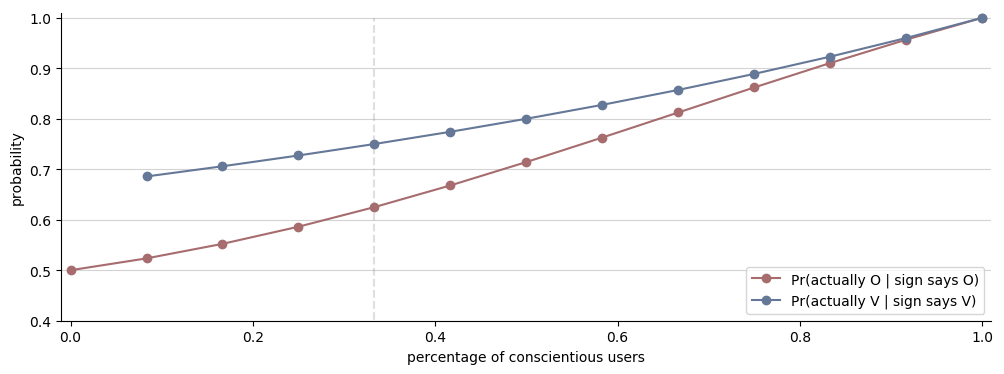

In [108]:
varying_pc_plot()

Note that, as predicted, as the percentage of conscientious users goes to $1$ the probability that the sign actually indicates the state of the bathroom approaches 1 as well.  As $p_C$ goes to $0$ some more interesting things happen.  

First, the probability that the bathroom is occupied given that the sign says occupied approaches $1/2$.  Thus when there are no conscientious users the sign offers zero information about the state of the bathroom.  

Also note that the value of the conditional probability when the sign says the bathroom is vacant is undefined. This makes sense from the analysis because we're studying the long-term trends of the system.  Remember that if upon entrance to the bathroom the sign already reads occupied, the conscientious user is the only one that will flip it back to vacant upon exiting.  So as soon as the sign reads occupied for the first time it will continue to read occupied forever and ever.    

### Appendix
***

The following function simulates the bathroom trial and estimates the transition probabilities for each of the valid state.  This served as a sanity check after doing the pencil-and-paper transition calculations. 

In [6]:
function bathroom_transitions(pc=1/3, M=100000)
    # ------------------------------------------------------------
    # Runs the bathroom trial simulation and estimates transition
    # probabilities. States in the matrix are ordered as 
    # (EV, AV, EO, AO, SO, CO).
    # Parameters: 
    #     pc: probability of conscientious user  
    # ------------------------------------------------------------
    
    # Initialize counting matrix
    P = zeros(8,8)
    
    # Local to Global map 
    lgmap = Dict(
    (1,1) => 1,
    (2,1) => 2,
    (3,1) => 3,
    (4,1) => 4,
    (1,2) => 5,
    (2,2) => 6,
    (3,2) => 7,
    (4,2) => 8,
    )
        
    
    # Initialize usage state from Multinouli distribution
    use_state = findfirst(rand(Multinomial(1,[1/2,(1-pc)/4,(1-pc)/4,pc/2])))
    
    # Initialize sign state (1-vacant, 2-occupied)
    sign_state = 1 
    
    for ii=1:M 
        
        prev_state = (use_state, sign_state)
        
        # current occupant leaves 
        sign_state = exit_bathroom(use_state, sign_state)
        
        # new occupant enters 
        use_state = findfirst(rand(Multinomial(1,[1/2,(1-pc)/4,(1-pc)/4,pc/2])))
        sign_state = enter_bathroom(use_state, sign_state)
        
        new_state = (use_state, sign_state)
        
        if ii%10==0
            P[lgmap[prev_state], lgmap[new_state]] += 1 
        end
        
    end
    
    P = P[[1,2,5,6,7,8],[1,2,5,6,7,8]]
    
    for ii=1:size(P,1)
        P[ii,:] = P[ii,:] / sum(P[ii,:])
    end
    
    return P
    
end

bathroom_transitions (generic function with 3 methods)

In [106]:
bathroom_transitions(1/3, 10000000)

6×6 Array{Float64,2}:
 0.498899  0.166431  0.0       0.0       0.166959  0.167711
 0.500671  0.16582   0.0       0.0       0.167678  0.165832
 0.0       0.0       0.499926  0.167802  0.16624   0.166032
 0.0       0.0       0.500402  0.168457  0.164508  0.166633
 0.0       0.0       0.501289  0.166729  0.16686   0.165122
 0.499883  0.168167  0.0       0.0       0.165122  0.166828